# HW 4 - Homes DataFrame

In this post, we will be considering the ```homes``` DataFrame from the 2004 American Housing Survey. This contains data on home values, demographics, schools, income, finance, mortgages, sales, neighborhood characteristics, noise, smells, state geography, and urban classification. We will be applying Linear Regression and Logistic Regression models in order to analyze how different factors impact or predict home value.



## Loading Packages and Settings

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.master("local[*]").getOrCreate()

## UDFs

We will be using a variety of User Defined Functions (UDFs) in order to perform functions necessary for our Logistic Regression Models. We will define our UDFs before we begin.

### marginal_effects

In [ ]:
def marginal_effects(model, means):
    """
    Compute marginal effects for all predictors in a PySpark GeneralizedLinearRegression model (logit)
    and return a formatted table with statistical significance and standard errors.

    Parameters:
        model: Fitted GeneralizedLinearRegression model (with binomial family and logit link).
        means: List of mean values for the predictor variables.

    Returns:
        - A formatted string containing the marginal effects table.
        - A Pandas DataFrame with marginal effects, standard errors, confidence intervals, and significance stars.
    """
    global assembler_predictors  # Use the global assembler_predictors list

    # Extract model coefficients, standard errors, and intercept
    coeffs = np.array(model.coefficients)
    std_errors = np.array(model.summary.coefficientStandardErrors)
    intercept = model.intercept

    # Compute linear combination of means and coefficients (XB)
    XB = np.dot(means, coeffs) + intercept

    # Compute derivative of logistic function (G'(XB))
    G_prime_XB = np.exp(XB) / ((1 + np.exp(XB)) ** 2)

    # Helper: significance stars.
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Create lists to store results
    results = []
    df_results = []  # For Pandas DataFrame

    for i, predictor in enumerate(assembler_predictors):
        # Compute marginal effect
        marginal_effect = G_prime_XB * coeffs[i]

        # Compute standard error of the marginal effect
        std_error = G_prime_XB * std_errors[i]

        # Compute z-score and p-value
        z_score = marginal_effect / std_error if std_error != 0 else np.nan
        p_value = 2 * (1 - norm.cdf(abs(z_score))) if not np.isnan(z_score) else np.nan

        # Compute confidence interval (95%)
        ci_lower = marginal_effect - 1.96 * std_error
        ci_upper = marginal_effect + 1.96 * std_error

        # Append results for table formatting
        results.append([
            predictor,
            f"{marginal_effect: .4f}",
            significance_stars(p_value),
            f"{std_error: .4f}",
            f"{ci_lower: .4f}",
            f"{ci_upper: .4f}"
        ])

        # Append results for Pandas DataFrame
        df_results.append({
            "Variable": predictor,
            "Marginal Effect": marginal_effect,
            "Significance": significance_stars(p_value),
            "Std. Error": std_error,
            "95% CI Lower": ci_lower,
            "95% CI Upper": ci_upper
        })

    # Convert results to formatted table
    table_str = tabulate(results, headers=["Variable", "Marginal Effect", "Significance", "Std. Error", "95% CI Lower", "95% CI Upper"],
                         tablefmt="pretty", colalign=("left", "decimal", "left", "decimal", "decimal", "decimal"))

    # Convert results to Pandas DataFrame
    df_results = pd.DataFrame(df_results)

    return table_str, df_results

# Example usage:
# means = [0.5, 30]  # Mean values for x1 and x2
# assembler_predictors = ['x1', 'x2']  # Define globally before calling the function
# table_output, df_output = marginal_effects(fitted_model, means)
# print(table_output)
# display(df_output)

### regression_table

In [ ]:
def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler.

    If the model’s labelCol (retrieved using getLabelCol()) starts with "log", an extra column showing np.exp(coeff)
    is added immediately after the beta estimate column for predictor rows. Additionally, np.exp() of the 95% CI
    Lower and Upper bounds is also added unless the predictor's name includes "log_". The Intercept row does not
    include exponentiated values.

    When labelCol starts with "log", the columns are ordered as:
        y: [label] | Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper | Exp(95% CI Lower) | Exp(95% CI Upper)

    Otherwise, the columns are:
        y: [label] | Beta | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute and a labelCol).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Determine if we should display exponential values for coefficients.
    is_log = model.getLabelCol().lower().startswith("log")

    # Extract coefficients and standard errors as NumPy arrays.
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element).
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Use provided tValues and pValues.
    df = model.summary.numInstances - len(coeffs) - 1
    t_critical = stats.t.ppf(0.975, df)
    p_values = model.summary.pValues

    # Helper: significance stars.
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build table rows for each feature.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se

        # Check if predictor contains "log_" to determine if exponentiation should be applied
        apply_exp = is_log and "log_" not in feature.lower()

        exp_beta = np.exp(beta) if apply_exp else ""
        exp_ci_lower = np.exp(ci_lower) if apply_exp else ""
        exp_ci_upper = np.exp(ci_upper) if apply_exp else ""

        if is_log:
            table.append([
                feature,            # Predictor name
                beta,               # Beta estimate
                exp_beta,           # Exponential of beta (or blank)
                significance_stars(p),
                se,
                p,
                ci_lower,
                ci_upper,
                exp_ci_lower,       # Exponential of 95% CI lower bound
                exp_ci_upper        # Exponential of 95% CI upper bound
            ])
        else:
            table.append([
                feature,
                beta,
                significance_stars(p),
                se,
                p,
                ci_lower,
                ci_upper
            ])

    # Process intercept.
    if intercept_se is not None:
        intercept_p = model.summary.pValues[0] if model.summary.pValues is not None else None
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""
        intercept_se = ""

    if is_log:
        table.append([
            "Intercept",
            model.intercept,
            "",                    # Removed np.exp(model.intercept)
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            "",
            ci_intercept_upper,
            ""
        ])
    else:
        table.append([
            "Intercept",
            model.intercept,
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            ci_intercept_upper
        ])

    # Append overall model metrics.
    if is_log:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", "", "", "", ""])
    else:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table rows.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            # Format Observations as integer with commas.
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if is_log:
                    # When is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Exp(Beta), 3: Sig, 4: Std. Error, 5: p-value,
                    # 6: 95% CI Lower, 7: 95% CI Upper, 8: Exp(95% CI Lower), 9: Exp(95% CI Upper).
                    if i in [1, 2, 4, 6, 7, 8, 9]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 5:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
                else:
                    # When not is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Sig, 3: Std. Error, 4: p-value, 5: 95% CI Lower, 6: 95% CI Upper.
                    if i in [1, 3, 5, 6]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 4:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Set header and column alignment based on whether label starts with "log"
    if is_log:
        headers = [
            f"y: {model.getLabelCol()}",
            "Beta", "Exp(Beta)", "Sig.", "Std. Error", "p-value",
            "95% CI Lower", "95% CI Upper", "Exp(95% CI Lower)", "Exp(95% CI Upper)"
        ]
        colalign = ("left", "right", "right", "center", "right", "right", "right", "right", "right", "right")
    else:
        headers = [f"y: {model.getLabelCol()}", "Beta", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"]
        colalign = ("left", "right", "center", "right", "right", "right", "right")

    table_str = tabulate(
        formatted_table,
        headers=headers,
        tablefmt="pretty",
        colalign=colalign
    )

    # Insert a dashed line after the Intercept row.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(model_1, assembler_1))

### add_dummy_variables

In [ ]:
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

### add_interaction_terms

In [ ]:
def add_interaction_terms(var_list1, var_list2, var_list3=None):
    """
    Creates interaction term columns in the global DataFrames dtrain and dtest.

    For two sets of variable names (which may represent categorical (dummy) or continuous variables),
    this function creates two-way interactions by multiplying each variable in var_list1 with each
    variable in var_list2.

    Optionally, if a third list of variable names (var_list3) is provided, the function also creates
    three-way interactions among each variable in var_list1, each variable in var_list2, and each variable
    in var_list3.

    Parameters:
        var_list1 (list): List of column names for the first set of variables.
        var_list2 (list): List of column names for the second set of variables.
        var_list3 (list, optional): List of column names for the third set of variables for three-way interactions.

    Returns:
        A flat list of new interaction column names.
    """
    global dtrain, dtest

    interaction_cols = []

    # Create two-way interactions between var_list1 and var_list2.
    for var1 in var_list1:
        for var2 in var_list2:
            col_name = f"{var1}_*_{var2}"
            dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            interaction_cols.append(col_name)

    # Create two-way interactions between var_list1 and var_list3.
    if var_list3 is not None:
      for var1 in var_list1:
          for var3 in var_list3:
              col_name = f"{var1}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # Create two-way interactions between var_list2 and var_list3.
    if var_list3 is not None:
      for var2 in var_list2:
          for var3 in var_list3:
              col_name = f"{var2}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # If a third list is provided, create three-way interactions.
    if var_list3 is not None:
        for var1 in var_list1:
            for var2 in var_list2:
                for var3 in var_list3:
                    col_name = f"{var1}_*_{var2}_*_{var3}"
                    dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    interaction_cols.append(col_name)

    return interaction_cols

 # Example
 # interaction_cols_brand_price = add_interaction_terms(dummy_cols_brand, ['log_price'])
 # interaction_cols_brand_ad_price = add_interaction_terms(dummy_cols_brand, dummy_cols_ad, ['log_price'])

### compare_reg_models

In [ ]:
def compare_reg_models(models, assemblers, names=None):
    """
    Produces a single formatted table comparing multiple regression models.

    For each predictor (the union across models, ordered by first appearance), the table shows
    the beta estimate (with significance stars) from each model (blank if not used).
    For a predictor, if a model's outcome (model.getLabelCol()) starts with "log", the cell displays
    both the beta and its exponential (separated by " / "), except when the predictor's name includes "log_".
    (The intercept row does not display exp(.))

    Additional rows for Intercept, Observations, R², and RMSE are appended.

    The header's first column is labeled "Predictor", and subsequent columns are
    "y: [outcome] ([name])" for each model.

    The table is produced in grid format (with vertical lines). A dashed line (using '-' characters)
    is inserted at the top, immediately after the header, and at the bottom.
    Additionally, immediately after the Intercept row, the border line is replaced with one using '='
    (to appear as, for example, "+==============================================+==========================+...").

    Parameters:
        models (list): List of fitted LinearRegression models.
        assemblers (list): List of corresponding VectorAssembler objects.
        names (list, optional): List of model names; defaults to "Model 1", "Model 2", etc.

    Returns:
        A formatted string containing the combined regression table.
    """
    # Default model names.
    if names is None:
        names = [f"Model {i+1}" for i in range(len(models))]

    # For each model, get outcome and determine if that model is log-transformed.
    outcomes = [m.getLabelCol() for m in models]
    is_log_flags = [out.lower().startswith("log") for out in outcomes]

    # Build an ordered union of predictors based on first appearance.
    ordered_predictors = []
    for assembler in assemblers:
        for feat in assembler.getInputCols():
            if feat not in ordered_predictors:
                ordered_predictors.append(feat)

    # Helper for significance stars.
    def significance_stars(p):
        if p is None:
            return ""
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build rows for each predictor.
    rows = []
    for feat in ordered_predictors:
        row = [feat]
        for m, a, is_log in zip(models, assemblers, is_log_flags):
            feats_model = a.getInputCols()
            if feat in feats_model:
                idx = feats_model.index(feat)
                beta = m.coefficients.toArray()[idx]
                p_val = m.summary.pValues[idx] if m.summary.pValues is not None else None
                stars = significance_stars(p_val)
                cell = f"{beta:.3f}{stars}"
                # Only add exp(beta) if model is log and predictor name does NOT include "log_"
                if is_log and ("log_" not in feat.lower()):
                    cell += f" / {np.exp(beta):,.3f}"
                row.append(cell)
            else:
                row.append("")
        rows.append(row)

    # Build intercept row (do NOT compute exp(intercept)).
    intercept_row = ["Intercept"]
    for m in models:
        std_all = np.array(m.summary.coefficientStandardErrors)
        coeffs = m.coefficients.toArray()
        if len(std_all) == len(coeffs) + 1:
            intercept_p = m.summary.pValues[0] if m.summary.pValues is not None else None
        else:
            intercept_p = None
        sig = significance_stars(intercept_p)
        cell = f"{m.intercept:.3f}{sig}"
        intercept_row.append(cell)
    rows.append(intercept_row)

    # Add Observations row.
    obs_row = ["Observations"]
    for m in models:
        obs = m.summary.numInstances
        obs_row.append(f"{int(obs):,}")
    rows.append(obs_row)

    # Add R² row.
    r2_row = ["R²"]
    for m in models:
        r2_row.append(f"{m.summary.r2:.3f}")
    rows.append(r2_row)

    # Add RMSE row.
    rmse_row = ["RMSE"]
    for m in models:
        rmse_row.append(f"{m.summary.rootMeanSquaredError:.3f}")
    rows.append(rmse_row)

    # Build header: first column "Predictor", then for each model: "y: [outcome] ([name])"
    header = ["Predictor"]
    for out, name in zip(outcomes, names):
        header.append(f"y: {out} ({name})")

    # Create table string using grid format.
    table_str = tabulate(rows, headers=header, tablefmt="grid", colalign=("left",) + ("right",)*len(models))

    # Split into lines.
    lines = table_str.split("\n")

    # Create a dashed line spanning the full width.
    full_width = len(lines[0])
    dash_line = '-' * full_width
    # Create an equals line by replacing '-' with '='.
    eq_line = dash_line.replace('-', '=')

    # Insert a dashed line after the header row.
    lines = table_str.split("\n")
    # In grid format, header and separator are usually the first two lines.
    lines.insert(2, dash_line)

    # Insert an equals line after the Intercept row.
    for i, line in enumerate(lines):
        if line.startswith("|") and "Intercept" in line:
            if i+1 < len(lines):
                lines[i+1] = eq_line
            break

    # Add dashed lines at the very top and bottom.
    final_table = dash_line + "\n" + "\n".join(lines) + "\n" + dash_line

    return final_table

# Example usage:
# print(compare_reg_models([model_1, model_2, model_3],
#                          [assembler_1, assembler_2, assembler_3],
#                          ["Model 1", "Model 2", "Model 3"]))

### compare_rmse

In [ ]:
def compare_rmse(test_dfs, label_col, pred_col="prediction", names=None):
    """
    Computes and compares RMSE values for a list of test DataFrames.

    For each DataFrame in test_dfs, this function calculates the RMSE between the actual outcome
    (given by label_col) and the predicted value (given by pred_col, default "prediction"). It then
    produces a formatted table where the first column header is empty and the first row's first cell is
    "RMSE", with each model's RMSE in its own column.

    Parameters:
        test_dfs (list): List of test DataFrames.
        label_col (str): The name of the outcome column.
        pred_col (str, optional): The name of the prediction column (default "prediction").
        names (list, optional): List of model names corresponding to the test DataFrames.
                                Defaults to "Model 1", "Model 2", etc.

    Returns:
        A formatted string containing a table that compares RMSE values for each test DataFrame,
        with one model per column.
    """
    # Set default model names if none provided.
    if names is None:
        names = [f"Model {i+1}" for i in range(len(test_dfs))]

    rmse_values = []
    for df in test_dfs:
        # Create a column for squared error.
        df = df.withColumn("error_sq", pow(col(label_col) - col(pred_col), 2))
        # Calculate RMSE: square root of the mean squared error.
        rmse = df.agg(sqrt(avg("error_sq")).alias("rmse")).collect()[0]["rmse"]
        rmse_values.append(rmse)

    # Build a single row table: first cell "RMSE", then one cell per model with the RMSE value.
    row = ["RMSE"] + [f"{rmse:.3f}" for rmse in rmse_values]

    # Build header: first column header is empty, then model names.
    header = [""] + names

    table_str = tabulate([row], headers=header, tablefmt="grid", colalign=("left",) + ("right",)*len(names))
    return table_str

# Example usage:
# print(compare_rmse([dtest_1, dtest_2, dtest_3], "log_sales", names=["Model 1", "Model 2", "Model 3"]))

### residual_plot

In [ ]:
def residual_plot(df, label_col, model_name):
    """
    Generates a residual plot for a given test dataframe.

    Parameters:
        df (DataFrame): Spark DataFrame containing the test set with predictions.
        label_col (str): The column name of the actual outcome variable.
        title (str): The title for the residual plot.

    Returns:
        None (displays the plot)
    """
    # Convert to Pandas DataFrame
    df_pd = df.select(["prediction", label_col]).toPandas()
    df_pd["residual"] = df_pd[label_col] - df_pd["prediction"]

    # Scatter plot of residuals vs. predicted values
    plt.scatter(df_pd["prediction"], df_pd["residual"], alpha=0.2, color="darkgray")

    # Use LOWESS smoothing for trend line
    smoothed = sm.nonparametric.lowess(df_pd["residual"], df_pd["prediction"])
    plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")

    # Add reference line at y=0
    plt.axhline(y=0, color="red", linestyle="--")

    # Labels and title (model_name)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    model_name = "Residual Plot for " + model_name
    plt.title(model_name)

    # Show plot
    plt.show()

# Example usage:
# residual_plot(dtest_1, "log_sales", "Model 1")

## Loading DataFrame - Homes

In [ ]:
homes = pd.read_csv(
  'https://bcdanl.github.io/data/american_housing_survey.csv'
)

homes.head()

,LPRICE,VALUE,STATE,METRO,ZINC2,HHGRAD,BATHS,BEDRMS,PER,ZADULT,...,EABAN,HOWH,HOWN,ODORA,STRNA,AMMORT,INTW,MATBUY,DWNPAY,FRSTHO
0,85000,150000,GA,rural,15600,No HS,2,3,1,1,...,0,good,good,0,0,50000,9,1,other,0
1,76500,130000,GA,rural,61001,HS Grad,2,3,5,2,...,0,good,bad,0,1,70000,5,1,other,1
2,93900,135000,GA,rural,38700,HS Grad,2,3,4,2,...,0,good,good,0,0,117000,6,0,other,1
3,100000,140000,GA,rural,80000,No HS,3,4,2,2,...,0,good,good,0,1,100000,7,1,prev home,0
4,100000,135000,GA,rural,61000,HS Grad,2,3,2,2,...,0,good,good,0,0,100000,4,1,other,1


## Exploratory Data Analysis

Before applying our Logistic Regression Model, let's explore some of the relationships in this DataFrame.

### Home Value vs Household Income

In [ ]:
homes['log_income'] = np.log(homes['ZINC2'])
homes['log_value'] = np.log(homes['VALUE'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='log_income', ylabel='log_value'>

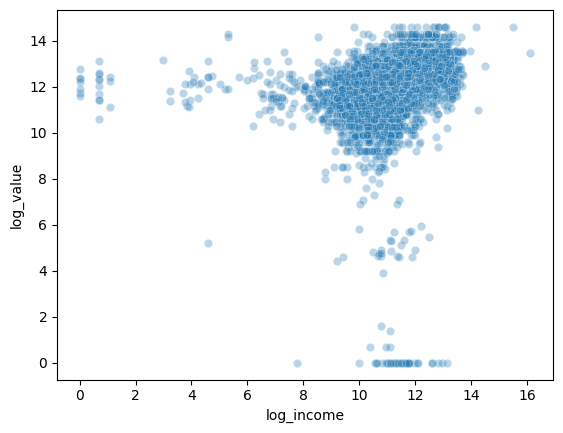

In [ ]:
sns.scatterplot(x=homes['log_income'], y=homes['log_value'], alpha=0.3)

**This scatterplot shows the relationship between the log of household income and the log of home values. I took the log of each variable to reduce skewness and make it easier to see patterns in the scatterplot. Here, we can see that a higher household income is generally associated with a higher house value.**

### Number of Bedrooms vs House Value

<Axes: xlabel='BEDRMS', ylabel='VALUE'>

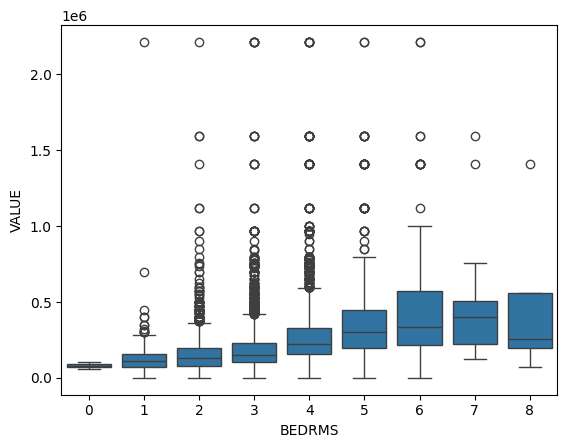

In [ ]:
sns.boxplot(x=homes['BEDRMS'], y=homes['VALUE'])

**These boxplots show the distribution of house values for different numbers of bedrooms. Houses with 6 and 8 bedrooms have the widest range in house value, whereas houses with only 1 bedroom have the least amount of variation in value. Houses with more bedrooms may have greater variation in value because they could range from older, lower value properties to newer, high value estates. Overall, as more bedrooms are added, home values tend to increase but with greater variability.**

### Junk in the Streets vs House Value

<Axes: xlabel='EJUNK', ylabel='VALUE'>

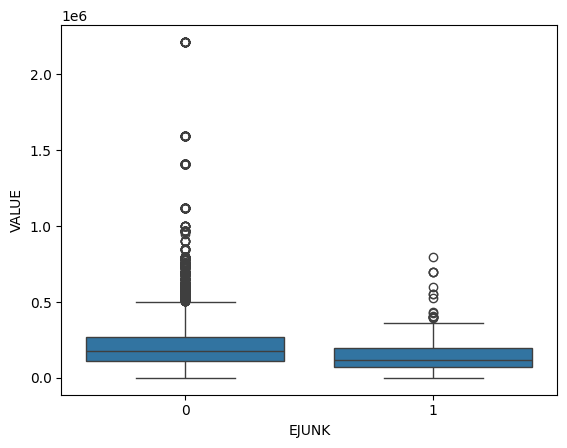

In [ ]:
sns.boxplot(x=homes['EJUNK'], y=homes['VALUE'])

**These boxplots show the distribution of house values for the amount of junk in the streets. Houses without junk in the streets have a slightly wider range of values than houses with junk in the streets. Additionally, houses with junk in the streets tend to be slightly less expensive than houses without junk in the streets.**

## Linear Regression

Next, we will build a Linear Regression Model to predict home values based on several variables and analyze the accurary of its predictions. For the predictor variables, we will use all of the variables in the DataFrame, excluding home value, the amount of the first mortgage payment, and the purchase price of the unit and land. The outcome variable will be the log value of the home.

### Log Transformation

In [ ]:
df = spark.createDataFrame(homes)
df = (
    df
    .withColumn("LOG_VALUE",
                log(df['VALUE']) )
)

### Training-Test Split

In [ ]:
dtrain, dtest = df.randomSplit([0.6, 0.4], seed = 1234)

### Assigning Dummy Variables

Before we begin training our models, we must add dummy variables for our categorical variables. To do this, we will apply our UDF for adding dummy variables. All observations must be numerical in order to train the Linear Regression Model.



In [ ]:
dummy_cols_STATE, ref_category_STATE = add_dummy_variables('STATE', 0)
dummy_cols_METRO, ref_category_METRO = add_dummy_variables('METRO', 0)
dummy_cols_HHGRAD, ref_category_HHGRAD = add_dummy_variables('HHGRAD', 1)
dummy_cols_HOWH, ref_category_HOWH = add_dummy_variables('HOWH', 0)
dummy_cols_HOWN, ref_category_HOWN = add_dummy_variables('HOWN', 0)
dummy_cols_DWNPAY, ref_category_DWNPAY = add_dummy_variables('DWNPAY', 0)

Reference category (dummy omitted): CA
Reference category (dummy omitted): rural
Reference category (dummy omitted): Bach
Reference category (dummy omitted): bad
Reference category (dummy omitted): bad
Reference category (dummy omitted): other


### Linear Regression (Model 1)

In [ ]:
# assembling predictors
conti_cols = ['ZINC2', 'BATHS', 'BEDRMS', 'PER', 'ZADULT', 'NUNITS', 'EAPTBL', 'ECOM1', 'ECOM2', 'EGREEN', 'EJUNK', 'ELOW1',
              'ESFD', 'ETRANS', 'EABAN', 'ODORA', 'STRNA', 'INTW', 'MATBUY', 'FRSTHO']

dummy_cols = dummy_cols_STATE + dummy_cols_METRO + dummy_cols_HHGRAD + dummy_cols_HOWH + dummy_cols_HOWN + dummy_cols_DWNPAY

assembler_predictors_1 = (
    conti_cols +
    dummy_cols
)

assembler_1 = VectorAssembler(
    inputCols = assembler_predictors_1,
    outputCol = "predictors"
)

dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

# training model
model_1 = (
    LinearRegression(featuresCol="predictors",
                     labelCol="LOG_VALUE")
    .fit(dtrain_1)
)

# making prediction
dtest_1 = model_1.transform(dtest_1)

# makting regression table
print( regression_table(model_1, assembler_1) )

+------------------+--------+-----------+------+------------+---------+--------------+--------------+-------------------+-------------------+
| y: LOG_VALUE     |   Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper | Exp(95% CI Lower) | Exp(95% CI Upper) |
+------------------+--------+-----------+------+------------+---------+--------------+--------------+-------------------+-------------------+
| ZINC2            |  0.000 |     1.000 | ***  |      0.014 |   0.000 |       -0.028 |        0.028 |             0.972 |             1.029 |
| BATHS            |  0.211 |     1.235 | ***  |      0.013 |   0.000 |        0.186 |        0.236 |             1.205 |             1.266 |
| BEDRMS           |  0.089 |     1.093 | ***  |      0.008 |   0.000 |        0.074 |        0.105 |             1.077 |             1.110 |
| PER              |  0.005 |     1.005 |      |      0.014 |   0.533 |       -0.022 |        0.032 |             0.978 |             1.032 |
| ZADU

Each predictor variable's statistical significance is rated by stars under the column "Sig.". Predictors that are not statisically significant do not have any stars. We can see in the regression table that not all of the predictor variables are statistically significant. In our next Linear Regression Model, we will only include variables that are statistically significant. We can then compare the two models and decide whether or not removing non-statistically significant variables impacts the accuracy of the model and functionality of the model.

### New Linear Regression (Model 2)



In [ ]:
# assembling predictors
conti_cols_2 = ['ZINC2', 'BATHS', 'BEDRMS', 'NUNITS', 'EJUNK',
              'ESFD', 'ETRANS', 'EABAN', 'INTW', 'FRSTHO']

dummy_cols = dummy_cols_STATE + dummy_cols_METRO + dummy_cols_HHGRAD + dummy_cols_HOWH + dummy_cols_HOWN + dummy_cols_DWNPAY

assembler_predictors_2 = (
    conti_cols_2 +
    dummy_cols
)

assembler_2 = VectorAssembler(
    inputCols = assembler_predictors_2,
    outputCol = "predictors"
)

dtrain_2 = assembler_2.transform(dtrain)
dtest_2  = assembler_2.transform(dtest)

# training model
model_2 = (
    LinearRegression(featuresCol="predictors",
                     labelCol="LOG_VALUE")
    .fit(dtrain_2)
)

# making prediction
dtest_2 = model_2.transform(dtest_2)

# makting regression table
print( regression_table(model_2, assembler_2) )

+------------------+--------+-----------+------+------------+---------+--------------+--------------+-------------------+-------------------+
| y: LOG_VALUE     |   Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper | Exp(95% CI Lower) | Exp(95% CI Upper) |
+------------------+--------+-----------+------+------------+---------+--------------+--------------+-------------------+-------------------+
| ZINC2            |  0.000 |     1.000 | ***  |      0.014 |   0.000 |       -0.028 |        0.028 |             0.972 |             1.028 |
| BATHS            |  0.213 |     1.238 | ***  |      0.012 |   0.000 |        0.190 |        0.236 |             1.210 |             1.267 |
| BEDRMS           |  0.087 |     1.091 | ***  |      0.001 |   0.000 |        0.086 |        0.088 |             1.089 |             1.092 |
| NUNITS           | -0.002 |     0.998 |  **  |      0.065 |   0.011 |       -0.129 |        0.126 |             0.879 |             1.134 |
| EJUN

### Model Comparison

We can compare the models by looking for differences in their beta, $R^2$, and RMSE values, as well as their residual plots.

#### Beta and $R^2$ values

In [ ]:
print(compare_reg_models([model_1, model_2],
                        [assembler_1, assembler_2],
                        ["Model 1", "Model 2"]))

--------------------------------------------------------------------------
+------------------+--------------------------+--------------------------+
| Predictor        |   y: LOG_VALUE (Model 1) |   y: LOG_VALUE (Model 2) |
--------------------------------------------------------------------------
+==================+==========================+==========================+
| ZINC2            |         0.000*** / 1.000 |         0.000*** / 1.000 |
+------------------+--------------------------+--------------------------+
| BATHS            |         0.211*** / 1.235 |         0.213*** / 1.238 |
+------------------+--------------------------+--------------------------+
| BEDRMS           |         0.089*** / 1.093 |         0.087*** / 1.091 |
+------------------+--------------------------+--------------------------+
| PER              |            0.005 / 1.005 |                          |
+------------------+--------------------------+--------------------------+
| ZADULT           |     

**The two models generally have similar or the same beta values for each predictor. They also have the same $R^2$ values. This suggests that one of the models may not be more accurate in predicting house value than the other and that the two are functionally equivalent.**

#### RMSE

In [ ]:
print(compare_rmse([dtest_1, dtest_2], "LOG_VALUE"))

+------+-----------+-----------+
|      |   Model 1 |   Model 2 |
+======+===========+===========+
| RMSE |     0.851 |     0.852 |
+------+-----------+-----------+


**The RMSE values for the two models are relatively the same, with Model 1 having a slightly lower value. This suggests that Model 1 may be a slightly better fit for the data.**

#### Residual Plots

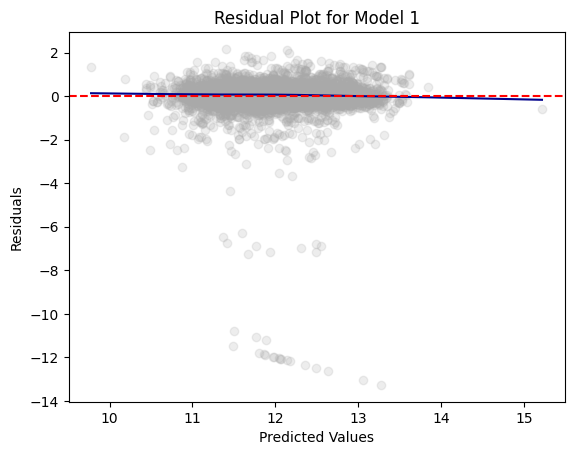

In [ ]:
residual_plot(dtest_1, "LOG_VALUE", "Model 1")

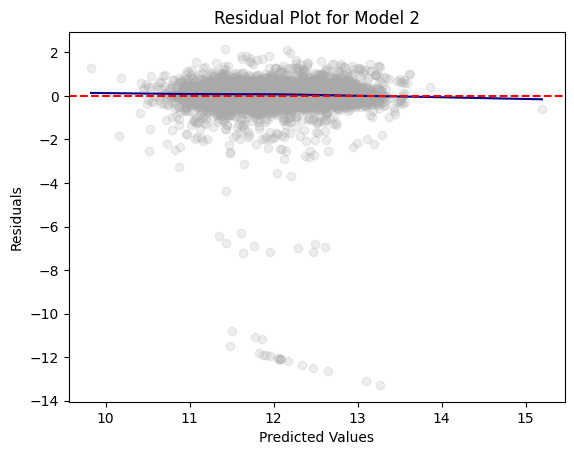

In [ ]:
residual_plot(dtest_2, "LOG_VALUE", "Model 2")

**The residual plots for Model 1 and Model 2 look relatively the same. This shows us that the models are able to predict the home value with the same or similar accuracy.**

**Overall, the residual plots, beta values, $R^2$ values, and RMSE values were relatively the same for both models. This proves that the variables removed in Model 2 were in fact not statistically significant. Their removal did not have a major impact on the Linear Regression model.**

## Logistic Regression

Next, we will build a Logistic Regression Model using the same DataFrame, ```homes```. However, this time we will have the model predict whether the buyer made a down payment of 20% or more. This outcome variable will be a new variable named "GT20DOWN". Our predictor variables will once again be all available variables, excluding the amount of the first mortgage and the purchase price of the unit and land.



### Outcome Variable

In [ ]:
df = df.withColumn("GT20DOWN", when((col("LPRICE") - col("AMMORT")) / col("LPRICE") > 0, 1).otherwise(0))

### Split into Training/Testing

In [ ]:
dtrain, dtest = df.randomSplit([0.6, 0.4], seed=1234)

### Dummy Variables

In [ ]:
dummy_cols_STATE, ref_category_STATE = add_dummy_variables('STATE', 0)
dummy_cols_METRO, ref_category_METRO = add_dummy_variables('METRO', 0)
dummy_cols_HHGRAD, ref_category_HHGRAD = add_dummy_variables('HHGRAD', 1)
dummy_cols_HOWH, ref_category_HOWH = add_dummy_variables('HOWH', 0)
dummy_cols_HOWN, ref_category_HOWN = add_dummy_variables('HOWN', 0)
dummy_cols_DWNPAY, ref_category_DWNPAY = add_dummy_variables('DWNPAY', 0)

Reference category (dummy omitted): CA
Reference category (dummy omitted): rural
Reference category (dummy omitted): Bach
Reference category (dummy omitted): bad
Reference category (dummy omitted): bad
Reference category (dummy omitted): other


In [ ]:

# Keep the name assembler_predictors unchanged,
#   as it will be used as a global variable in the marginal_effects UDF.
assembler_predictors = (
    conti_cols_2 +
    dummy_cols
)

assembler_3 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_3 = assembler_3.transform(dtrain)
dtest_3  = assembler_3.transform(dtest)

In [ ]:
# training the model
model_3 = (
    GeneralizedLinearRegression(featuresCol="predictors",
                                labelCol="GT20DOWN",
                                family="binomial",
                                link="logit")
    .fit(dtrain_3)
)

In [ ]:
dtrain_3 = model_3.transform(dtrain_3)
dtest_3 = model_3.transform(dtest_3)

In [ ]:
model_3.summary

Coefficients:
         Feature Estimate Std Error  T Value P Value
     (Intercept)   0.7348    0.1998   3.6781  0.0002
           ZINC2   0.0000    0.0000   0.8766  0.3807
           BATHS   0.2872    0.0407   7.0522  0.0000
          BEDRMS  -0.0784    0.0323  -2.4263  0.0153
          NUNITS   0.0129    0.0061   2.1077  0.0351
           EJUNK  -0.2353    0.1723  -1.3658  0.1720
            ESFD  -0.2221    0.0997  -2.2287  0.0258
          ETRANS  -0.1349    0.0844  -1.5981  0.1100
           EABAN  -0.3862    0.1205  -3.2045  0.0014
            INTW  -0.0686    0.0148  -4.6394  0.0000
          FRSTHO  -0.3151    0.0568  -5.5470  0.0000
        STATE_CO  -0.1912    0.0984  -1.9438  0.0519
        STATE_CT   0.7224    0.1092   6.6139  0.0000
        STATE_GA   0.0132    0.1038   0.1277  0.8984
        STATE_IL   0.3506    0.1939   1.8087  0.0705
        STATE_IN   0.2030    0.1031   1.9687  0.0490
        STATE_LA   0.4599    0.1255   3.6651  0.0002
        STATE_MO   0.2093    0.1

### Marginal Effects

We can use the marginal effect of a predictor variable to analyze the relationship or association between the predictor and outcome variable. In this case, we will interpret the association between first-time homeownership and the probability of making a 20%+ down payment. Additionally, we will be able to interpret the association between number of bedrooms in the home and the probability of making a 20%+ down payment.

In [ ]:
# Compute means
means_df = dtrain_3.select([mean(col).alias(col) for col in assembler_predictors])

# Collect the results as a list
means = means_df.collect()[0]
means_list = [means[col] for col in assembler_predictors]

In [ ]:
table_output, df_ME = marginal_effects(model_3, means_list)
print(table_output)

+------------------+-----------------+--------------+------------+--------------+--------------+
| Variable         | Marginal Effect | Significance | Std. Error | 95% CI Lower | 95% CI Upper |
+------------------+-----------------+--------------+------------+--------------+--------------+
| ZINC2            |          0.0000 |              |     0.0000 |      -0.0000 |       0.0000 |
| BATHS            |          0.0674 | ***          |     0.0096 |       0.0487 |       0.0861 |
| BEDRMS           |         -0.0184 | **           |     0.0076 |      -0.0333 |      -0.0035 |
| NUNITS           |          0.0030 | **           |     0.0014 |       0.0002 |       0.0058 |
| EJUNK            |         -0.0552 |              |     0.0404 |      -0.1345 |       0.0240 |
| ESFD             |         -0.0521 | **           |     0.0234 |      -0.0980 |      -0.0063 |
| ETRANS           |         -0.0316 |              |     0.0198 |      -0.0705 |       0.0072 |
| EABAN            |         -

**The marginal effect of first time homebuyers (FRSTHO) is $-0.0739$. This shows that first time home buyers are 7.39% less likely to make a 20% down payment.**

**The marginal effect of the number of bedrooms (BEDRMS) is $-0.0184$. This shows that an additional bedroom is associated with a 1.84% lower probability of making a 20% down payment.**

## Adding Interaction Terms

Let's take a closer look at the relationship between number of bedrooms, first-time homebuyers, and the probability of making a 20%+ down payment. To do this, we will fit a new Logistic Regression Model using all the previously included predictors, plus the interaction between first-time homebuyers, ```FRSTHO```, and number of bedrooms, ```BEDRMS```. This will allow us to interpret how the relationship between the number of bedrooms and the probability of making a 20%+ down payment varies depending on whether the buyer is a first-time homebuyer.

### Interaction Between ```FRSTHO``` and ```BEDRMS```

In [ ]:
interaction_cols_FRSTHO_BEDRMS = add_interaction_terms(['FRSTHO'], ['BEDRMS'])

### New Logistic Regression (with Interaction Terms)

In [ ]:
assembler_predictors = (
    conti_cols_2 +
    dummy_cols +
    interaction_cols_FRSTHO_BEDRMS
)

assembler_4 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_4 = assembler_4.transform(dtrain)
dtest_4  = assembler_4.transform(dtest)

In [ ]:
# training the model
model_4 = (
    GeneralizedLinearRegression(featuresCol="predictors",
                                labelCol="GT20DOWN",
                                family="binomial",
                                link="logit")
    .fit(dtrain_4)
)

In [ ]:
dtrain_4 = model_4.transform(dtrain_4)
dtest_4 = model_4.transform(dtest_4)

In [ ]:
model_4.summary

Coefficients:
         Feature Estimate Std Error  T Value P Value
     (Intercept)   0.5973    0.2126   2.8099  0.0050
           ZINC2   0.0000    0.0000   0.8195  0.4125
           BATHS   0.2829    0.0408   6.9307  0.0000
          BEDRMS  -0.0322    0.0406  -0.7929  0.4278
          NUNITS   0.0126    0.0060   2.0798  0.0375
           EJUNK  -0.2374    0.1721  -1.3793  0.1678
            ESFD  -0.2240    0.0995  -2.2500  0.0244
          ETRANS  -0.1363    0.0844  -1.6158  0.1061
           EABAN  -0.3890    0.1205  -3.2279  0.0012
            INTW  -0.0684    0.0148  -4.6252  0.0000
          FRSTHO   0.0198    0.1860   0.1066  0.9151
        STATE_CO  -0.1957    0.0984  -1.9878  0.0468
        STATE_CT   0.7175    0.1092   6.5688  0.0000
        STATE_GA   0.0121    0.1039   0.1167  0.9071
        STATE_IL   0.3454    0.1938   1.7820  0.0748
        STATE_IN   0.2013    0.1031   1.9519  0.0509
        STATE_LA   0.4578    0.1255   3.6480  0.0003
        STATE_MO   0.2041    0.1

**The coefficient of the interaction term between first time homebuyers (FRSTHO) and number of bedrooms (BEDRMS) is $-0.1076$. This means that for first time homebuyers, each additional bedroom decreases the chance that the homebuyer will make a 20% down payment by 0.1076 units.**

### Marginal Effects

In [ ]:
# Compute means
means_df = dtrain_4.select([mean(col).alias(col) for col in assembler_predictors])

# Collect the results as a list
means = means_df.collect()[0]
means_list = [means[col] for col in assembler_predictors]

In [ ]:
table_output, df_ME = marginal_effects(model_4, means_list) # Instead of mean values, some other representative values can also be chosen.
print(table_output)

+------------------+-----------------+--------------+------------+--------------+--------------+
| Variable         | Marginal Effect | Significance | Std. Error | 95% CI Lower | 95% CI Upper |
+------------------+-----------------+--------------+------------+--------------+--------------+
| ZINC2            |          0.0000 |              |     0.0000 |      -0.0000 |       0.0000 |
| BATHS            |          0.0664 | ***          |     0.0096 |       0.0476 |       0.0852 |
| BEDRMS           |         -0.0076 |              |     0.0095 |      -0.0262 |       0.0111 |
| NUNITS           |          0.0029 | **           |     0.0014 |       0.0002 |       0.0057 |
| EJUNK            |         -0.0557 |              |     0.0404 |      -0.1349 |       0.0235 |
| ESFD             |         -0.0526 | **           |     0.0234 |      -0.0983 |      -0.0068 |
| ETRANS           |         -0.0320 |              |     0.0198 |      -0.0708 |       0.0068 |
| EABAN            |         -

**The marginal effect of the interaction term between first time homebuyers (FRSTHO) and number of bedrooms (BEDRMS) is $-0.0253$. This means that for each additional bedroom, first time homebuyers are 2.53% less likely to make a 20% down payment compared to non-first time homebuyers.**

## Two More Logistic Regression Models

Finally, we will fit two more Logistic Regression Models in order to predict home value for two subsets of home data. One subset and model will feature only homes worth greater than or equal to 175k. The other subset will feature homes worth less than 175k. We can compare the models' residual deviance, $RMSE$, and classification performance to evaluate whether or not performance changes for different home value levels.

### Split DataFrame

In [ ]:
greater_than_equal_175000 = df[df['VALUE'] >= 175000]
less_than_175000 = df[df['VALUE'] < 175000]

### Homes worth VALUE ≥ 175k

#### Split into Training/Testing

In [ ]:
dtrain, dtest = greater_than_equal_175000.randomSplit([0.6, 0.4], seed=1234)

#### Dummy Variables

In [ ]:
dummy_cols_STATE, ref_category_STATE = add_dummy_variables('STATE', 0)
dummy_cols_METRO, ref_category_METRO = add_dummy_variables('METRO', 0)
dummy_cols_HHGRAD, ref_category_HHGRAD = add_dummy_variables('HHGRAD', 1)
dummy_cols_HOWH, ref_category_HOWH = add_dummy_variables('HOWH', 0)
dummy_cols_HOWN, ref_category_HOWN = add_dummy_variables('HOWN', 0)
dummy_cols_DWNPAY, ref_category_DWNPAY = add_dummy_variables('DWNPAY', 0)

Reference category (dummy omitted): CA
Reference category (dummy omitted): rural
Reference category (dummy omitted): Bach
Reference category (dummy omitted): bad
Reference category (dummy omitted): bad
Reference category (dummy omitted): other


#### Logistic Regression Model

In [ ]:
assembler_predictors = (
    conti_cols_2 +
    dummy_cols
)

assembler_5 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_5 = assembler_5.transform(dtrain)
dtest_5  = assembler_5.transform(dtest)

In [ ]:
# training the model
model_5 = (
    GeneralizedLinearRegression(featuresCol="predictors",
                                labelCol="GT20DOWN",
                                family="binomial",
                                link="logit")
    .fit(dtrain_5)
)

In [ ]:
dtrain_5 = model_5.transform(dtrain_5)
dtest_5 = model_5.transform(dtest_5)

In [ ]:
model_5.summary

Coefficients:
         Feature Estimate Std Error T Value P Value
     (Intercept)   0.6684    0.3251  2.0562  0.0398
           ZINC2   0.0000    0.0000 -0.0764  0.9391
           BATHS   0.3301    0.0567  5.8208  0.0000
          BEDRMS  -0.1040    0.0465 -2.2361  0.0253
          NUNITS   0.0234    0.0134  1.7432  0.0813
           EJUNK  -0.5695    0.3093 -1.8415  0.0656
            ESFD  -0.3985    0.1853 -2.1513  0.0315
          ETRANS  -0.1742    0.1410 -1.2356  0.2166
           EABAN  -0.6480    0.2510 -2.5822  0.0098
            INTW  -0.0567    0.0275 -2.0606  0.0393
          FRSTHO  -0.3161    0.0888 -3.5608  0.0004
        STATE_CO  -0.0415    0.1061 -0.3908  0.6959
        STATE_CT   0.8530    0.1275  6.6922  0.0000
        STATE_GA   0.2964    0.1367  2.1676  0.0302
        STATE_IL   0.4020    0.4308  0.9331  0.3508
        STATE_IN   0.7344    0.1791  4.1011  0.0000
        STATE_LA   0.7326    0.2326  3.1494  0.0016
        STATE_MO   0.8763    0.1818  4.8199  0.000

In [ ]:
# Compute confusion matrix
dtest_5 = dtest_5.withColumn("predicted_class", when(col("prediction") > .02, 1).otherwise(0))
conf_matrix = dtest_5.groupBy("GT20DOWN", "predicted_class").count().orderBy("GT20DOWN", "predicted_class")

TP = dtest_5.filter((col("GT20DOWN") == 1) & (col("predicted_class") == 1)).count()
FP = dtest_5.filter((col("GT20DOWN") == 0) & (col("predicted_class") == 1)).count()
FN = dtest_5.filter((col("GT20DOWN") == 1) & (col("predicted_class") == 0)).count()
TN = dtest_5.filter((col("GT20DOWN") == 0) & (col("predicted_class") == 0)).count()

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
average_rate = (TP + FN) / (TP + TN + FP + FN)  # Proportion of actual at-risk babies
enrichment = precision / average_rate


# Print formatted confusion matrix with labels
print("\n Confusion Matrix:\n")
print("                     Predicted")
print("            |  Negative  |  Positive  ")
print("------------+------------+------------")
print(f"Actual Neg. |    {TN:5}   |    {FP:5}  |")
print("------------+------------+------------")
print(f"Actual Pos. |    {FN:5}   |    {TP:5}  |")
print("------------+------------+------------")


print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity:  {specificity:.4f}")
print(f"Average Rate: {average_rate:.4f}")
print(f"Enrichment:   {enrichment:.4f} (Relative Precision)")



 Confusion Matrix:

                     Predicted
            |  Negative  |  Positive  
------------+------------+------------
Actual Neg. |        0   |      960  |
------------+------------+------------
Actual Pos. |        0   |     2160  |
------------+------------+------------
Accuracy:  0.6923
Precision: 0.6923
Recall (Sensitivity): 1.0000
Specificity:  0.0000
Average Rate: 0.6923
Enrichment:   1.0000 (Relative Precision)


#### AUC and ROC

AUC: 0.6741


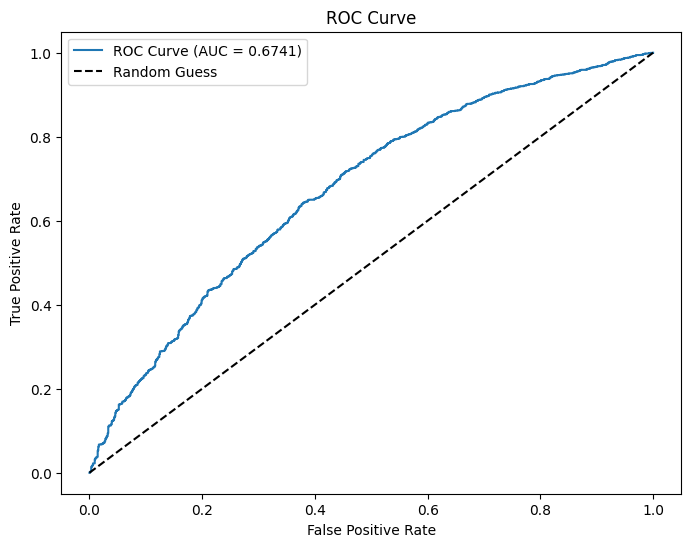

In [ ]:
# Use probability of the positive class (y=1)
evaluator = BinaryClassificationEvaluator(labelCol="GT20DOWN", rawPredictionCol="prediction", metricName="areaUnderROC")

# Evaluate AUC
auc = evaluator.evaluate(dtest_5)

print(f"AUC: {auc:.4f}")  # Higher is better (closer to 1)

# Convert to Pandas
pdf = dtest_5.select("prediction", "GT20DOWN").toPandas()

# Compute ROC curve
fpr, tpr, _ = roc_curve(pdf["GT20DOWN"], pdf["prediction"])

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Homes worth VALUE < 175k

In [ ]:
dtrain, dtest = less_than_175000.randomSplit([0.6, 0.4], seed=1234)

In [ ]:
dummy_cols_STATE, ref_category_STATE = add_dummy_variables('STATE', 0)
dummy_cols_METRO, ref_category_METRO = add_dummy_variables('METRO', 0)
dummy_cols_HHGRAD, ref_category_HHGRAD = add_dummy_variables('HHGRAD', 1)
dummy_cols_HOWH, ref_category_HOWH = add_dummy_variables('HOWH', 0)
dummy_cols_HOWN, ref_category_HOWN = add_dummy_variables('HOWN', 0)
dummy_cols_DWNPAY, ref_category_DWNPAY = add_dummy_variables('DWNPAY', 0)

Reference category (dummy omitted): CA
Reference category (dummy omitted): rural
Reference category (dummy omitted): Bach
Reference category (dummy omitted): bad
Reference category (dummy omitted): bad
Reference category (dummy omitted): other


In [ ]:
assembler_predictors = (
    conti_cols_2 +
    dummy_cols
)

assembler_6 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_6 = assembler_6.transform(dtrain)
dtest_6  = assembler_6.transform(dtest)

In [ ]:
# training the model
model_6 = (
    GeneralizedLinearRegression(featuresCol="predictors",
                                labelCol="GT20DOWN",
                                family="binomial",
                                link="logit")
    .fit(dtrain_6)
)

In [ ]:
dtrain_6 = model_6.transform(dtrain_6)
dtest_6 = model_6.transform(dtest_6)

In [ ]:
model_6.summary

Coefficients:
         Feature Estimate Std Error T Value P Value
     (Intercept)   1.0004    0.3609  2.7724  0.0056
           ZINC2   0.0000    0.0000  2.4733  0.0134
           BATHS   0.2564    0.0641  4.0021  0.0001
          BEDRMS  -0.1801    0.0469 -3.8381  0.0001
          NUNITS   0.0288    0.0117  2.4521  0.0142
           EJUNK  -0.4302    0.2098 -2.0506  0.0403
            ESFD  -0.1264    0.1233 -1.0256  0.3051
          ETRANS  -0.0607    0.1006 -0.6037  0.5461
           EABAN  -0.2049    0.1320 -1.5520  0.1207
            INTW  -0.0681    0.0177 -3.8552  0.0001
          FRSTHO  -0.2598    0.0747 -3.4807  0.0005
        STATE_CO  -0.1942    0.3192 -0.6083  0.5430
        STATE_CT   0.5233    0.3094  1.6911  0.0908
        STATE_GA  -0.4573    0.2993 -1.5280  0.1265
        STATE_IL   0.2285    0.3448  0.6625  0.5076
        STATE_IN  -0.1152    0.2925 -0.3939  0.6936
        STATE_LA   0.1373    0.3037  0.4520  0.6513
        STATE_MO  -0.2127    0.3007 -0.7074  0.479

In [ ]:
# Compute confusion matrix
dtest_6 = dtest_6.withColumn("predicted_class", when(col("prediction") > .02, 1).otherwise(0))
conf_matrix = dtest_6.groupBy("GT20DOWN", "predicted_class").count().orderBy("GT20DOWN", "predicted_class")

TP = dtest_6.filter((col("GT20DOWN") == 1) & (col("predicted_class") == 1)).count()
FP = dtest_6.filter((col("GT20DOWN") == 0) & (col("predicted_class") == 1)).count()
FN = dtest_6.filter((col("GT20DOWN") == 1) & (col("predicted_class") == 0)).count()
TN = dtest_6.filter((col("GT20DOWN") == 0) & (col("predicted_class") == 0)).count()

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
average_rate = (TP + FN) / (TP + TN + FP + FN)  # Proportion of actual at-risk babies
enrichment = precision / average_rate


# Print formatted confusion matrix with labels
print("\n Confusion Matrix:\n")
print("                     Predicted")
print("            |  Negative  |  Positive  ")
print("------------+------------+------------")
print(f"Actual Neg. |    {TN:5}   |    {FP:5}  |")
print("------------+------------+------------")
print(f"Actual Pos. |    {FN:5}   |    {TP:5}  |")
print("------------+------------+------------")


print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity:  {specificity:.4f}")
print(f"Average Rate: {average_rate:.4f}")
print(f"Enrichment:   {enrichment:.4f} (Relative Precision)")



 Confusion Matrix:

                     Predicted
            |  Negative  |  Positive  
------------+------------+------------
Actual Neg. |        0   |     1422  |
------------+------------+------------
Actual Pos. |        0   |     1659  |
------------+------------+------------
Accuracy:  0.5385
Precision: 0.5385
Recall (Sensitivity): 1.0000
Specificity:  0.0000
Average Rate: 0.5385
Enrichment:   1.0000 (Relative Precision)


#### AUC and ROC

AUC: 0.6519


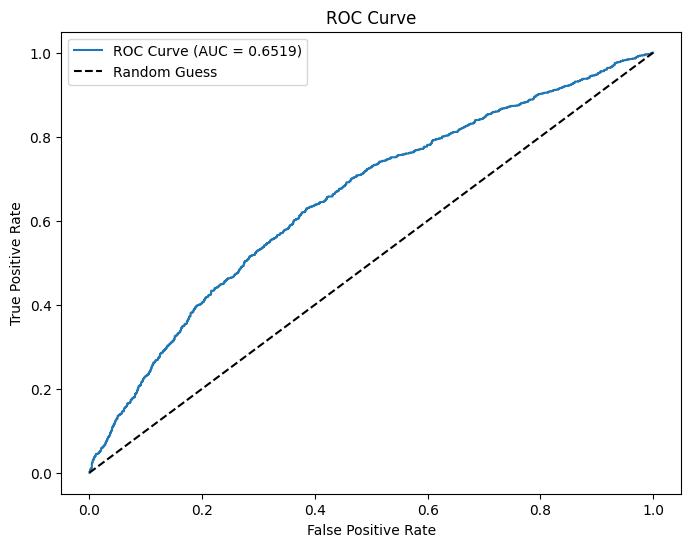

In [ ]:
# Use probability of the positive class (y=1)
evaluator = BinaryClassificationEvaluator(labelCol="GT20DOWN", rawPredictionCol="prediction", metricName="areaUnderROC")

# Evaluate AUC
auc = evaluator.evaluate(dtest_6)

print(f"AUC: {auc:.4f}")  # Higher is better (closer to 1)

# Convert to Pandas
pdf = dtest_6.select("prediction", "GT20DOWN").toPandas()

# Compute ROC curve
fpr, tpr, _ = roc_curve(pdf["GT20DOWN"], pdf["prediction"])

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Interpretation

**The logistic regression model for houses with a value of 175k or greater has a residual deviance of $5328.8668$. The model for houses with a value of less than 175k has a residual deviance of $6060.5538$. This shows that the model for houses with a value of 175k or greater fits the data better because it has a lower residual deviance. In other words, the predictors more accurately predict if the homebuyer makes a 20% down payment for houses with a value of 175k or greater.**

**The model for houses with a value of 175k or higher has an accuracy of $0.6923$, whereas the model for houses with a value of less than 175k has an accuracy of $0.5385$. Once again, the model for higher value houses makes more accurate predictions because of its higher accuracy.**

**The AUC of the model for houses with greater value is $0.6741$. The AUC of the model for lower value houses is $0.6519$. The AUC for the model with higher value houses is slightly closer to 1 than the model with lower value houses. This supports the previous two claims that the model with higher value houses more accurately predicts if the homebuyer makes a 20% down payment.**
